# Notebook on Getting Graph Embeddings from Trained Models


Steps involved to recreate/adopt:

1. Train a model and get the corresponding ckpt file
2. Load the ckpt
3. Get the layers up to the embedding
4. t-sne, umap, etc to get embeddings
5. Plot with corresponding labels for data


## 1) Load model


In [1]:
from bondnet.model.training_utils import (
    get_grapher,
    load_model_lightning,
)

config = {
    "model": {
        "restore": True,
        "restore_path": "../../../tests/model/test_save_load/test.ckpt",  # path to ckpt
    }
}

model_restart = load_model_lightning(config["model"], load_dir="./test_save_load/")

/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


:::RESTORING MODEL FROM EXISTING FILE:::
:::MODEL LOADED:::


## 2) Gather Dataset of interest


In [2]:
from bondnet.data.datamodule import BondNetLightningDataModule

dataset_loc = "../../../tests/data/testdata/barrier_100.json"

config = {
    "dataset": {
        "data_dir": dataset_loc,
        "target_var": "dG_barrier",
    },
    "model": {
        "extra_features": ["bond_length"],
        "extra_info": [],
        "debug": False,
        "classifier": False,
        "classif_categories": 3,
        "filter_species": [3, 6],
        "filter_outliers": False,
        "filter_sparse_rxns": False,
        "restore": False,
    },
    "optim": {
        "val_size": 0.0,
        "test_size": 0.85,
        "batch_size": 4,
        "num_workers": 1,
    },
}

dm = BondNetLightningDataModule(config)
feat_size, feat_name = dm.prepare_data()
dm.setup(stage="predict")

reading file from: ../../../tests/data/testdata/barrier_100.json
rxn raw len: 100
Program finished in 0.6320824599824846 seconds
.............failures.............
reactions len: 100
valid ind len: 100
bond break fail count: 		0
default fail count: 		0
sdf map fail count: 		0
product bond fail count: 	0
about to group and organize
number of grouped reactions: 100
features: 240
labels: 100
molecules: 240
constructing graphs & features....
number of graphs valid: 240
number of graphs: 240


In [5]:
embedding_list = []

nodes = ["atom", "bond", "global"]
embedding_size = model_restart.hparams.embedding_size
batch_size = len(dm.test_ds)

direct_concat_name = model_restart.hparams.set2set_ntypes_direct
gat_out = model_restart.hparams.gated_hidden_size[-1]
readout_out_size = gat_out * 2 + gat_out * 2
readout_out_size += gat_out * len(direct_concat_name)

for it, (batched_graph, label) in enumerate(dm.test_dataloader()):
    feats = {nt: batched_graph.nodes[nt].data["feat"] for nt in nodes}
    target = label["value"].view(-1)
    norm_atom = label["norm_atom"]
    norm_bond = label["norm_bond"]
    stdev = label["scaler_stdev"]
    reactions = label["reaction"]

    embeddings = model_restart.feature_before_fc(
        graph=batched_graph,
        feats=feats,
        reactions=reactions,
        norm_atom=norm_atom,
        norm_bond=norm_bond,
    )

    # add to embedding list
    numpy_embeddings = embeddings.detach().numpy()
    embedding_list.append(numpy_embeddings)
    # reshape embeddings

## UMAP


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import seaborn as sns
import umap
%matplotlib inline

CPU times: user 7.02 s, sys: 13.2 ms, total: 7.04 s
Wall time: 2.97 s


Text(0.5, 1.0, 'UMAP embedding')

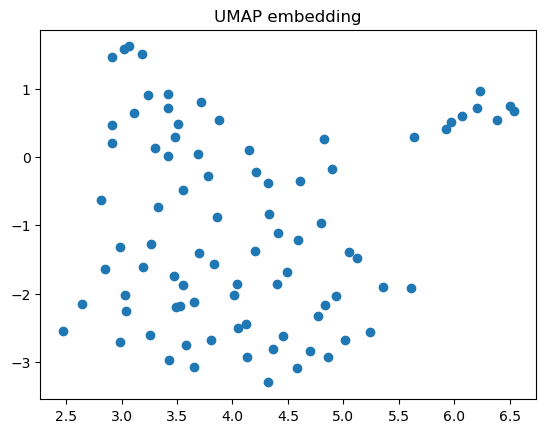

In [7]:
fit = umap.UMAP()
%time u = fit.fit_transform(embedding_list[0])
plt.scatter(u[:,0], u[:,1])
plt.title('UMAP embedding')

# Now the same with hydro dataset + labels


In [6]:
from bondnet.data.datamodule import BondNetLightningDataModule

dataset_loc = "../../dataset/holdout_nonprot.json"

config = {
    "dataset": {
        "data_dir": dataset_loc,
        "target_var": "dG_sp",
    },
    "model": {
        "extra_features": ["bond_length"],
        "extra_info": ["functional_group_reacted"],
        "debug": False,
        "classifier": False,
        "classif_categories": 3,
        "filter_species": [3, 6],
        "filter_outliers": False,
        "filter_sparse_rxns": False,
        "restore": False,
    },
    "optim": {
        "val_size": 0.0,
        "test_size": 0.85,
        "batch_size": 4,
        "num_workers": 1,
    },
}

dm = BondNetLightningDataModule(config)
feat_size, feat_name = dm.prepare_data()
dm.setup(stage="predict")

reading file from: ../../dataset/holdout_nonprot.json
rxn raw len: 719
Program finished in 5.309856323059648 seconds
.............failures.............
reactions len: 719
valid ind len: 719
bond break fail count: 		0
default fail count: 		0
sdf map fail count: 		0
product bond fail count: 	0
about to group and organize
number of grouped reactions: 719
features: 2315
labels: 719
molecules: 2315
constructing graphs & features....
number of graphs valid: 2315
number of graphs: 2315


In [7]:
embedding_list = []
label_list = []
functional_group_list = []
nodes = ["atom", "bond", "global"]
embedding_size = model_restart.hparams.embedding_size
batch_size = len(dm.test_ds)

direct_concat_name = model_restart.hparams.set2set_ntypes_direct
gat_out = model_restart.hparams.gated_hidden_size[-1]
readout_out_size = gat_out * 2 + gat_out * 2
readout_out_size += gat_out * len(direct_concat_name)

for it, (batched_graph, label) in enumerate(dm.test_dataloader()):
    feats = {nt: batched_graph.nodes[nt].data["feat"] for nt in nodes}
    target = label["value"].view(-1)
    norm_atom = label["norm_atom"]
    norm_bond = label["norm_bond"]
    stdev = label["scaler_stdev"]
    reactions = label["reaction"]

    functional_group_temp = [
        i.extra_info["functional_group_reacted"] for i in reactions
    ]
    functional_group_list.append(functional_group_temp)

    embeddings = model_restart.feature_before_fc(
        graph=batched_graph,
        feats=feats,
        reactions=reactions,
        norm_atom=norm_atom,
        norm_bond=norm_bond,
    )

    # add to embedding list
    numpy_embeddings = embeddings.detach().numpy()
    embedding_list.append(numpy_embeddings)

In [8]:
# one hot encode functional group
from sklearn.preprocessing import OneHotEncoder

functional_group_temp = np.array(functional_group_list).reshape(-1, 1)
enc = OneHotEncoder(handle_unknown="ignore")
encoded = enc.fit_transform(functional_group_temp)
# get bins from encoder
enc.categories_
# convert from one hot to numpy array
functional_group = encoded.toarray()
# convert to non one hot
functional_group = np.argmax(functional_group, axis=1)

In [9]:
fit = umap.UMAP()
%time u = fit.fit_transform(embedding_list[0])


def parition_by_label(umap_raw, partition_labels):
    """
    Partition UMAP embedding by labels
    """
    dict_partition = {}
    for i in np.unique(partition_labels):
        dict_partition[i] = umap_raw[partition_labels == i]
    return dict_partition

partitioned_umap = parition_by_label(u, functional_group)


CPU times: user 26.5 s, sys: 24.4 ms, total: 26.5 s
Wall time: 1.72 s


(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'UMAP embedding'}>)

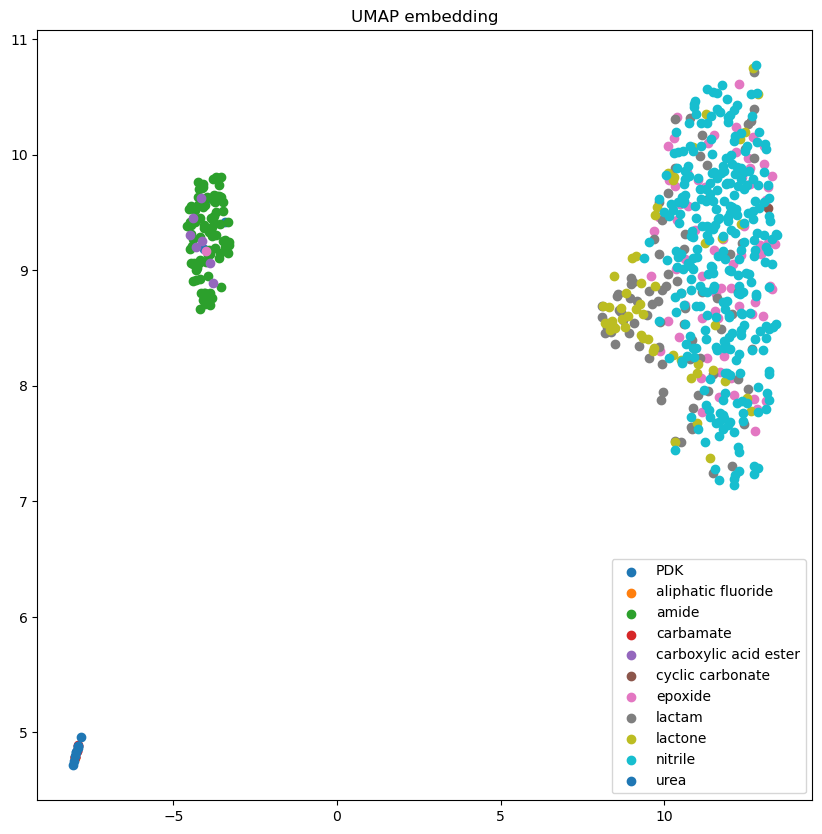

In [10]:
def plot_partitioned_umap(partitioned_umap, labels):
    """
    Plot partitioned UMAP embedding
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for ind, i in enumerate(partitioned_umap.keys()):
        ax.scatter(
            partitioned_umap[i][:, 0], partitioned_umap[i][:, 1], label=labels[ind]
        )
    ax.legend()
    ax.set_title("UMAP embedding")
    return fig, ax


plot_partitioned_umap(partitioned_umap, enc.categories_[0])